In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import geopandas as gpd

from my_bbs_anal_funcs import *

# import itables
# itables.init_notebook_mode()
# itables.init_notebook_mode(all_interactive=True)


plt.rcParams['axes.labelsize'] = 14  # Sets default font size for axis labels
plt.rcParams['xtick.labelsize'] = 12  # Sets default font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 12  # Sets default font size for y-tick labels
plt.rcParams['axes.titlesize'] = 16  # Sets default font size for axes titles
plt.rcParams['figure.titlesize'] = 18  # Sets default font size for figure titles
plt.rcParams['legend.fontsize'] = 12  # Sets default font size for legends


/home/horo/bin/bbs/my_bbs_anal_funcs.py:306: SyntaxWarning: invalid escape sequence '\d'
  stop_columns = df.filter(regex='^Stop\d+$')


# Breeding Bird Survey (BBS)
This repository contains the code and data for the Breeding Bird Survey (BBS) analysis. The BBS is a long-term, large-scale, international bird monitoring program that provides data on the population trends of North American birds.

**official website**: https://www.pwrc.usgs.gov/BBS/
- data repository [here](https://www.sciencebase.gov/catalog/item/52b1dfa8e4b0d9b325230cd9)



## Reading the Species file

here's the output of the `SpeciesList.csv`

In [7]:
spps = pd.read_csv('SpeciesList.csv')
display(spps)

,Seq,AOU,English_Common_Name,French_Common_Name,Order,Family,Genus,Species
0,6,1770,Black-bellied Whistling-Duck,Dendrocygne à ventre noir,Anseriformes,Anatidae,Dendrocygna,autumnalis
1,7,1780,Fulvous Whistling-Duck,Dendrocygne fauve,Anseriformes,Anatidae,Dendrocygna,bicolor
2,8,1760,Emperor Goose,Oie empereur,Anseriformes,Anatidae,Anser,canagicus
3,9,1690,Snow Goose,Oie des neiges,Anseriformes,Anatidae,Anser,caerulescens
4,10,1691,(Blue Goose) Snow Goose,Oie des neiges (forme bleue),Anseriformes,Anatidae,Anser,caerulescens (blue form)
...,...,...,...,...,...,...,...,...
758,1332,5980,Indigo Bunting,Passerin indigo,Passeriformes,Cardinalidae,Passerina,cyanea
759,1333,5986,hybrid Lazuli Bunting x Indigo Bunting,hybride Passerin azuré x Passerin indigo,Passeriformes,Cardinalidae,Passerina,amoena x cyanea
760,1336,6000,Varied Bunting,Passerin varié,Passeriformes,Cardinalidae,Passerina,versicolor
761,1337,6010,Painted Bunting,Passerin nonpareil,Passeriformes,Cardinalidae,Passerina,ciris


## Reading Route file

we will add a column to indicate the route id as `ruta`. It will be the merge of `ruta`=`CoutryNum`+`StateNum`+Route`

In [8]:
# print(os.listdir('.'))
routes = pd.read_csv('./Routes.csv', encoding='ISO-8859-1')

routes['ruta'] = pad_series_elements(routes['CountryNum'],3) + pad_series_elements(routes['StateNum'],2) + pad_series_elements(routes['Route'],2)

routes.head()

,CountryNum,StateNum,Route,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID,ruta
0,840,2,1,ST FLORIAN,1,34.868688,-87.604142,14,27,1,1,8400201
1,840,2,2,HILLSBORO,0,34.638675,-87.191292,14,24,1,1,8400202
2,840,2,3,FLORENCE,0,34.800000,-87.733333,14,24,1,1,8400203
3,840,2,4,TRADE,1,34.029788,-87.059235,13,28,1,1,8400204
4,840,2,5,SUMMITT,0,34.201669,-86.493409,13,28,1,1,8400205


In [9]:
routes['RouteTypeID'].describe()

count    5824.000000
mean        1.004293
std         0.065383
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: RouteTypeID, dtype: float64

## Reading abundance data from Stop files

In [10]:
data = read_routes_BBS('50-StopData/')

# data = read_routes_BBS('50-StopData (2)/1997ToPresent_SurveyWide/', match_pattern='f*.csv')


data.head()

Found 9 CSV files starting with 'F*.csv':
  - Fifty10.csv
  - Fifty4.csv
  - Fifty9.csv
  - Fifty3.csv
  - Fifty5.csv
  - Fifty2.csv
  - Fifty8.csv
  - Fifty1.csv
  - Fifty6.csv


,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Stop1,Stop2,Stop3,...,Stop41,Stop42,Stop43,Stop44,Stop45,Stop46,Stop47,Stop48,Stop49,Stop50
0,6240441,124,93,6,101,2000,70,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,6240441,124,93,6,101,2000,510,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6240441,124,93,6,101,2000,2300,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,6240441,124,93,6,101,2000,2550,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6240441,124,93,6,101,2000,3900,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Number of individuals (abundance) per route

We sum the abundance of each species across the 50 stops per route. The result is a dataframe with the columns `ruta`, `species` (AOU), and `Number of individuals`.

Also add a column `ruta` indexing a unique ID which is the merge of `CoutryNum`+`StateNum`+Route`.

(We can then pivot the dataframe to have one row per route and one column per species, with the values being the number of individuals observed. --todo)

In [11]:
Totals = pd.concat([data[data.columns[:7].tolist()],data.iloc[:,-50:].sum(axis=1)], axis=1)
Totals.rename(columns={0: 'Number of individuals'}, inplace=True)

Totals['ruta'] = pad_series_elements(Totals['CountryNum'],3)  + pad_series_elements(Totals['StateNum'],2) + pad_series_elements(Totals['Route'],2)

In [12]:
Totals['Year'].describe()

count    3.849449e+06
mean     2.009666e+03
std      7.612052e+00
min      1.967000e+03
25%      2.003000e+03
50%      2.010000e+03
75%      2.016000e+03
max      2.023000e+03
Name: Year, dtype: float64

Adding geo coordinates of the routes. 
- The coordinates are the starting geographical coordinates of each route.



In [13]:
Totals  = Totals.merge(routes.iloc[:,3:], on='ruta', how='left')


We may also look at the following filters: 
- We filter out years prior to 1980
- We filter out non-reliable routes (retaining those with `RPID` equal to 101)

In [14]:
Totals[(Totals['Year'] > 1990) & (Totals['RPID'] == 101)]

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Number of individuals,ruta,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID
0,6240441,124,93,6,101,2000,70,2,1249306,SIMPSON LAKE,1,60.902640,-129.233430,68,4,1,1
1,6240441,124,93,6,101,2000,510,1,1249306,SIMPSON LAKE,1,60.902640,-129.233430,68,4,1,1
2,6240441,124,93,6,101,2000,2300,4,1249306,SIMPSON LAKE,1,60.902640,-129.233430,68,4,1,1
3,6240441,124,93,6,101,2000,2550,1,1249306,SIMPSON LAKE,1,60.902640,-129.233430,68,4,1,1
4,6240441,124,93,6,101,2000,3900,2,1249306,SIMPSON LAKE,1,60.902640,-129.233430,68,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849444,6382865,840,63,917,101,2023,7180,13,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2
3849445,6382865,840,63,917,101,2023,7310,1,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2
3849446,6382865,840,63,917,101,2023,7360,4,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2
3849447,6382865,840,63,917,101,2023,7550,2,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2


# Summary for total dataset


1. **Species**
We need to build a table listing the species, the earliest year in which the species was found, the last year,  and the number of routes in which the species has been recorded

That is, columns could be:
 - spp
 - min year
 - max year
 - n_routes
  
2. **Routes**
This is a geographic view. We will need to build a table listing the main properties of routes. One option is to build a table that will list each route, route coords, the year of first sample, the year of last sample and the number of species sampled. We could also add a vector with the richness per year.

That is, columns
 - Route ID
 - (lon, lat)
 - first year
 - last year
 - total richness 

> There's a total of 4522 unique routes starting in 1967 until 2023

In [15]:
spp_summary = Totals[['AOU','ruta','Year']].groupby(['AOU']).agg(['count','min','max']).reset_index()
# spp_summary.columns
spp_summary.drop(columns=[('ruta','min'),('ruta','max'),('Year','count')],inplace=True)
spp_summary.columns =['AOU','n_rutas','first_year','last_year']
spp_summary['timeseries length'] = spp_summary['last_year'] - spp_summary['first_year']

spp_summary = spp_summary.merge(spps.iloc[:, 1:],on='AOU',how='left')

display(spp_summary.sort_values(by='n_rutas',ascending=False))

,AOU,n_rutas,first_year,last_year,timeseries length,English_Common_Name,French_Common_Name,Order,Family,Genus,Species
243,3160,62703,1967,2023,56,Mourning Dove,Tourterelle triste,Columbiformes,Columbidae,Zenaida,macroura
718,7610,59588,1968,2023,55,American Robin,Merle d'Amérique,Passeriformes,Turdidae,Turdus,migratorius
450,4980,57456,1967,2023,56,Red-winged Blackbird,Carouge à épaulettes,Passeriformes,Icteridae,Agelaius,phoeniceus
445,4950,56305,1967,2023,56,Brown-headed Cowbird,Vacher à tête brune,Passeriformes,Icteridae,Molothrus,ater
435,4880,54303,1968,2023,55,American Crow,Corneille d'Amérique,Passeriformes,Corvidae,Corvus,brachyrhynchos
...,...,...,...,...,...,...,...,...,...,...,...
296,3731,1,1998,1998,0,Whiskered Screech-Owl,Petit-duc à moustaches,Strigiformes,Strigidae,Megascops,trichopsis
14,120,1,2007,2007,0,Tufted Puffin,Macareux huppé,Charadriiformes,Alcidae,Fratercula,cirrhata
710,7539,1,1997,1997,0,unid. Blue-gray / Black-tailed Gnatcatcher,unid Gobemoucheron gris-bleu / à queue noire,Passeriformes,Polioptilidae,Polioptila,caerulea / melanura
728,16600,1,2009,2009,0,Sinaloa Wren,Troglodyte du Sinaloa,Passeriformes,Troglodytidae,Thryophilus,sinaloa


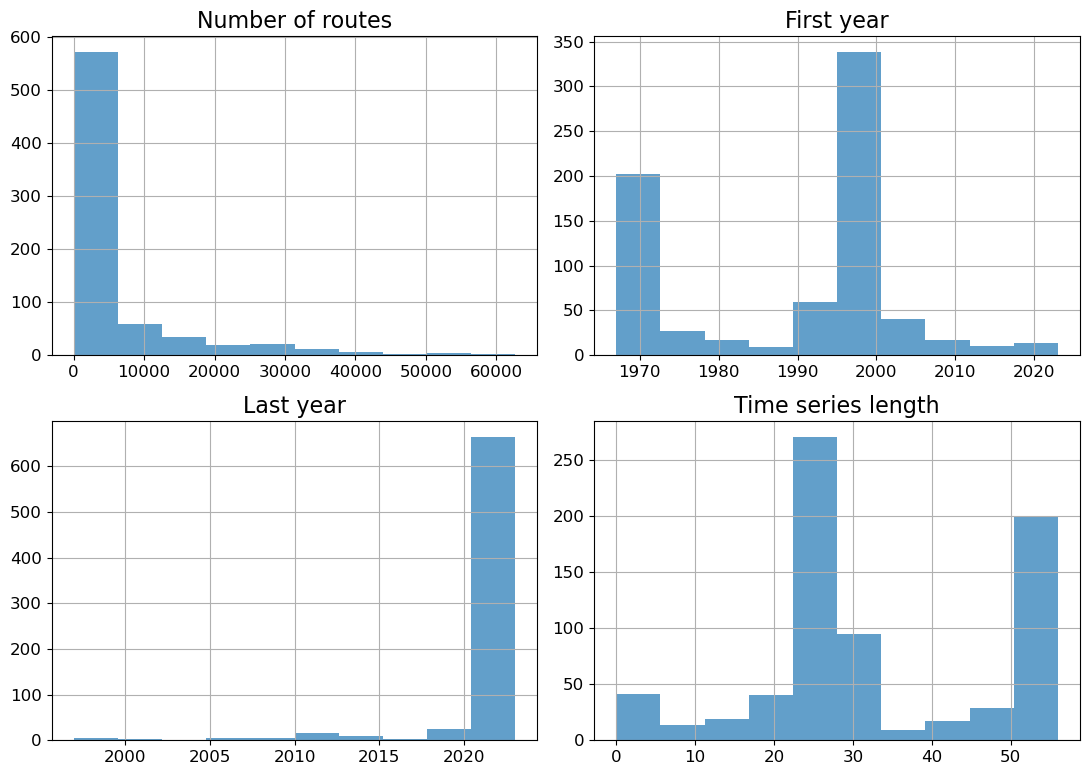

In [16]:
tmp = spp_summary.iloc[:,1:5]
tmp.rename(columns={'n_rutas':'Number of routes','first_year':'First year','last_year':'Last year','timeseries length':'Time series length'}, inplace=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))
tmp.hist(ax=axes, alpha=.7, density=False)
plt.suptitle('')
plt.tight_layout()

del tmp, fig, axes  

### Timeseries length distribution

- the frequency of timeseries length across all species.
- the number of routes per species and the length of their timeseries

Text(0.5, 0, 'Time series length (years)')

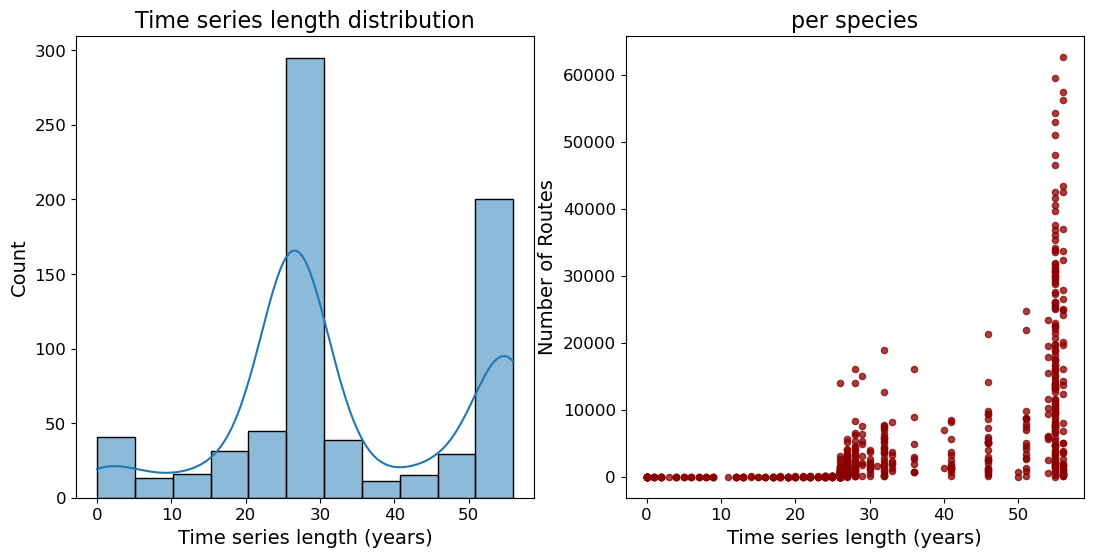

In [17]:

# Create a figure with 1 row and 2 columns of subplots

# Create the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

sns.histplot(data=spp_summary, x='timeseries length',kde=True, ax=axes[0])

spp_summary.plot.scatter(x='timeseries length', y='n_rutas', alpha=.75, ax=axes[1],color='darkred')
axes[0].set_title('Time series length distribution')
axes[0].set_xlabel('Time series length (years)')
axes[1].set_title('per species')
axes[1].set_ylabel('Number of Routes')
axes[1].set_xlabel('Time series length (years)')


In [ ]:
filtd = spp_summary[(spp_summary['first_year']>=1990) & (spp_summary['timeseries length']>=30) & (spp_summary['n_rutas']>=500)].sort_values(by=['timeseries length','n_rutas'],ascending=False)

# display(filtd)

Compute the fraction of years in which the species was sampled (out of the total number of years since the first year it was sampled).

In [19]:
# aous = [4930,3160,7610,4980,5190,5930,4880,5810,6130,6882]

prct = list()
for i in spp_summary['AOU']:
    # name = get_spp_name(i,spps) # get species name
    yrs = Totals[Totals['AOU']==i]['Year'].drop_duplicates() # years found
    # prct = len(yrs) / (max(yrs)-min(yrs)) # fraction of years found
    if max(yrs)-min(yrs):  # if
        prct.append(len(yrs) / (max(yrs)-min(yrs)))
    else:
        prct.append(0.0)
    # print(name['spp'],'('+name['Common Name']+'):',prct)

spp_summary['prct_years'] = prct


In [20]:
spp_summary.sort_values(by='prct_years',ascending=False,inplace=True)   
spp_summary[spp_summary['timeseries length']>=30].head(20)

,AOU,n_rutas,first_year,last_year,timeseries length,English_Common_Name,French_Common_Name,Order,Family,Genus,Species,prct_years
98,1500,1925,1993,2023,30,Ring-necked Duck,Fuligule à collier,Anseriformes,Anatidae,Aythya,collaris,1.000000
269,3420,8172,1990,2023,33,Swainson's Hawk,Buse de Swainson,Accipitriformes,Accipitridae,Buteo,swainsoni,0.969697
725,7680,7772,1991,2023,32,Mountain Bluebird,Merlebleu azuré,Passeriformes,Turdidae,Sialia,currucoides,0.968750
571,6170,18960,1991,2023,32,Northern Rough-winged Swallow,Hirondelle à ailes hérissées,Passeriformes,Hirundinidae,Stelgidopteryx,serripennis,0.968750
407,4660,12669,1991,2023,32,Willow Flycatcher,Moucherolle des saules,Passeriformes,Tyrannidae,Empidonax,traillii,0.968750
677,7250,3957,1993,2023,30,Marsh Wren,Troglodyte des marais,Passeriformes,Troglodytidae,Cistothorus,palustris,0.966667
224,3000,3717,1993,2023,30,Ruffed Grouse,Gélinotte huppée,Galliformes,Phasianidae,Bonasa,umbellus,0.966667
580,6260,1697,1993,2023,30,Philadelphia Vireo,Viréo de Philadelphie,Passeriformes,Vireonidae,Vireo,philadelphicus,0.966667
3,20,1160,1993,2023,30,Red-necked Grebe,Grèbe jougris,Podicipediformes,Podicipedidae,Podiceps,grisegena,0.966667
97,1490,2713,1993,2023,30,Lesser Scaup,Petit Fuligule,Anseriformes,Anatidae,Aythya,affinis,0.966667


In [14]:
# spp_summary[spp_summary['timeseries length']>=50]
# display(spp_summary)
spp_summary.to_csv('spp_summaries.csv')

## We may look at a few species

The most abundant bird species in the U.S. can vary by region and year, but based on BBS data, some of the most consistently numerous species are:

### Top 10 Most Abundant Bird Species in the USA

| Rank | Common Name           | AOU   | Scientific Name           | Notes                                                                                   |
|------|-----------------------|-------|---------------------------|-----------------------------------------------------------------------------------------|
| 1    | European Starling     | 4930  | *Sturnus vulgaris*        | Non-native, introduced in the 19th century, now one of the most common birds.           |
| 2    | Mourning Dove         | 3160  | *Zenaida macroura*        | Widespread, found in many habitats including suburbs and farmlands.                      |
| 3    | American Robin        | 7610  | *Turdus migratorius*      | Familiar across the country, known for its red breast and presence in gardens.           |
| 4    | Red-winged Blackbird  | 4980  | *Agelaius phoeniceus*     | Abundant near wetlands, forms large flocks.                                              |
| 5    | House Finch           | 5190  | *Haemorhous mexicanus*    | Native to western U.S., now common in backyards nationwide.                              |
| 6    | Northern Cardinal     | 5930  | *Cardinalis cardinalis*   | Easily recognized, especially the male's vibrant red plumage.                            |
| 7    | American Crow         | 4880  | *Corvus brachyrhynchos*   | Highly adaptable and intelligent, found in rural and urban environments.                 |
| 8    | Song Sparrow          | 5810  | *Melospiza melodia*       | Wide distribution, known for its variety of songs.                                       |
| 9    | Barn Swallow          | 6130  | *Hirundo rustica*         | Long-distance migrant, often nests on human-made structures.                             |
| 10   | House Sparrow         | 6882  | *Passer domesticus*       | Introduced species, extremely abundant in urban and suburban areas.                      |

Text(0, 0.5, 'Individuals')

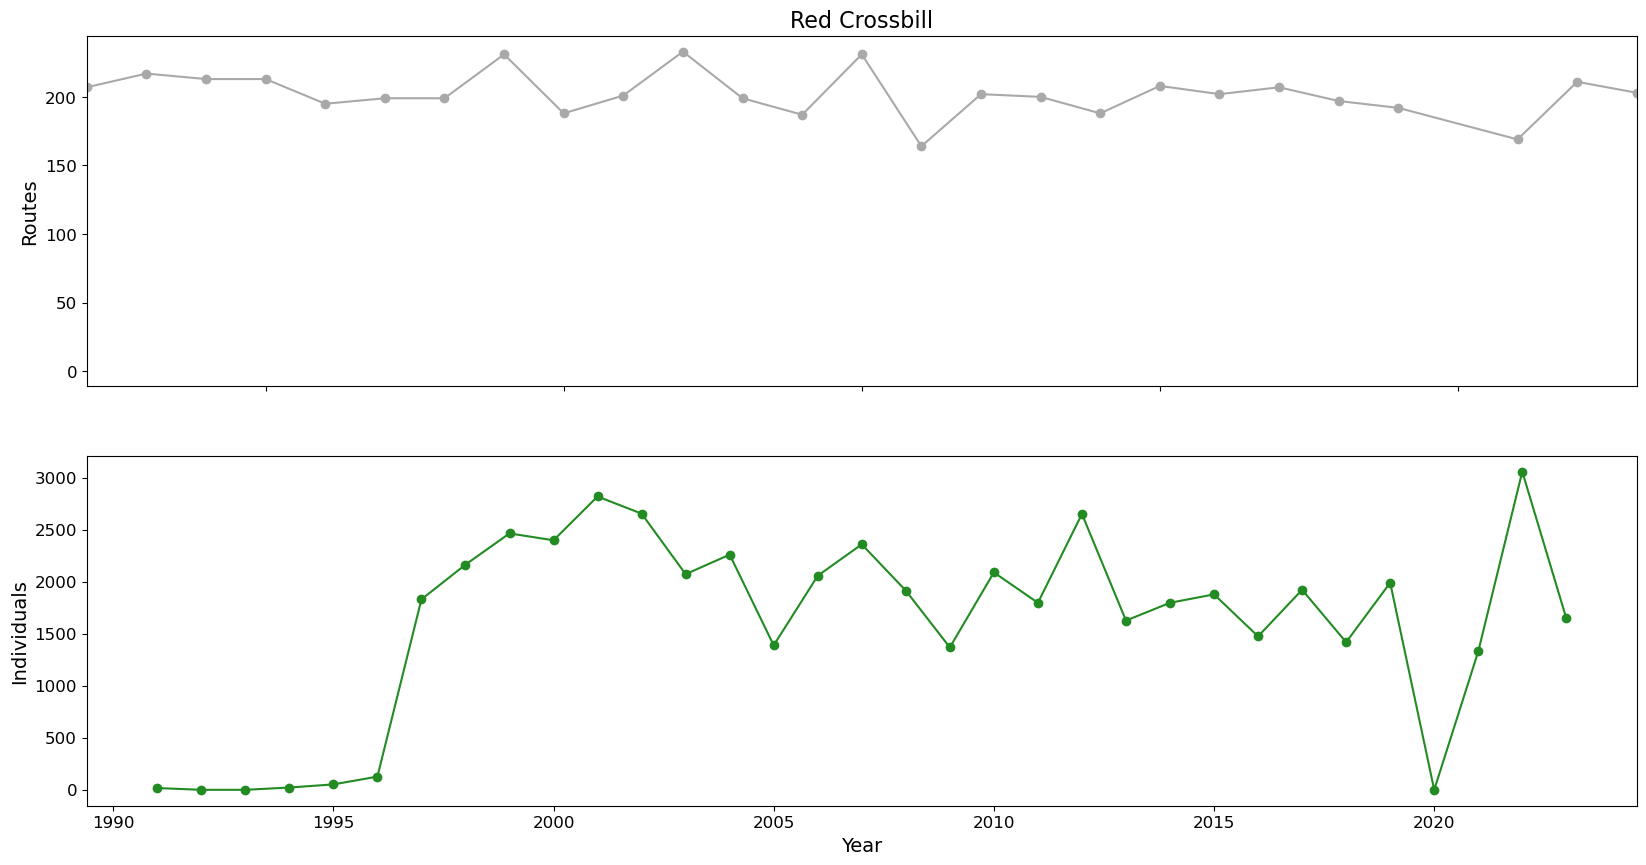

<Figure size 1500x500 with 0 Axes>

<Figure size 2000x400 with 0 Axes>

In [35]:
# Totals[(Totals['RouteDataID']==6346138) & (Totals['AOU']==2060)]['Year']

# spp = 4920 # Piñon Jay  ([Gymnorhinus cyanocephalus](https://www.allaboutbirds.org/guide/Pinyon_Jay/))
# spp = 2060 # 
# sppname = 'American Robin'

spp = 5210
sppname = get_spp_name(spp,spps)['Common Name']


# Plot the number of routes per year for the specified species

fig, axes = plt.subplots( 2,1, figsize=(20, 10))
plt.figure(figsize=(15, 5))
Totals[Totals['AOU']==spp][['Year','ruta']].groupby('Year').count().plot(kind='line', title=sppname,
                                                                         linestyle='-', marker='o',ax=axes[0],
                                                                         legend='',color='darkgrey')
axes[0].set_xlabel('')
axes[0].set_ylabel('Routes')

axes[0].set_xticklabels([])
axes[0].set_xlim(1997, 2023)

# total abundance
d = Totals[Totals['AOU']==spp][['Year','Number of individuals']].groupby('Year').sum().reset_index()#.plot('Year','Number of individuals')
all_years = pd.DataFrame({'Year': range(d['Year'].min(), d['Year'].max() + 1)})

dd = pd.merge(all_years, d, on='Year', how='left').fillna(0)

plt.figure(figsize=(20, 4))
dd.plot('Year','Number of individuals',linestyle='-', marker='o',
        ax=axes[1],legend='',color='Forestgreen')
axes[1].set_ylabel('Individuals')

# Totals[Totals['AOU']==4920]

In [1]:

# for i,r in spp_summary[['AOU','English_Common_Name']].iterrows():
#     spp = r['AOU']
#     sppname = r['English_Common_Name']
#     plot_ts_routests(spp,sppname,Totals,spp_summary,plotit=False)


In [4]:

# # fig,axes = plt.figure(figsize=(20, 4),nrows=1,cols=2)
# d =  Totals[Totals['AOU']==spp][['Year','Number of individuals']].groupby('Year').sum().reset_index()#.plot('Year','Number of individuals')
# all_years = pd.DataFrame({'Year': range(d['Year'].min(), d['Year'].max() + 1)})


# dd = pd.merge(all_years, d, on='Year', how='left').fillna(0)

# dd.plot('Year','Number of individuals',linestyle='-', marker='o',
#         title=sppname)


### Maps

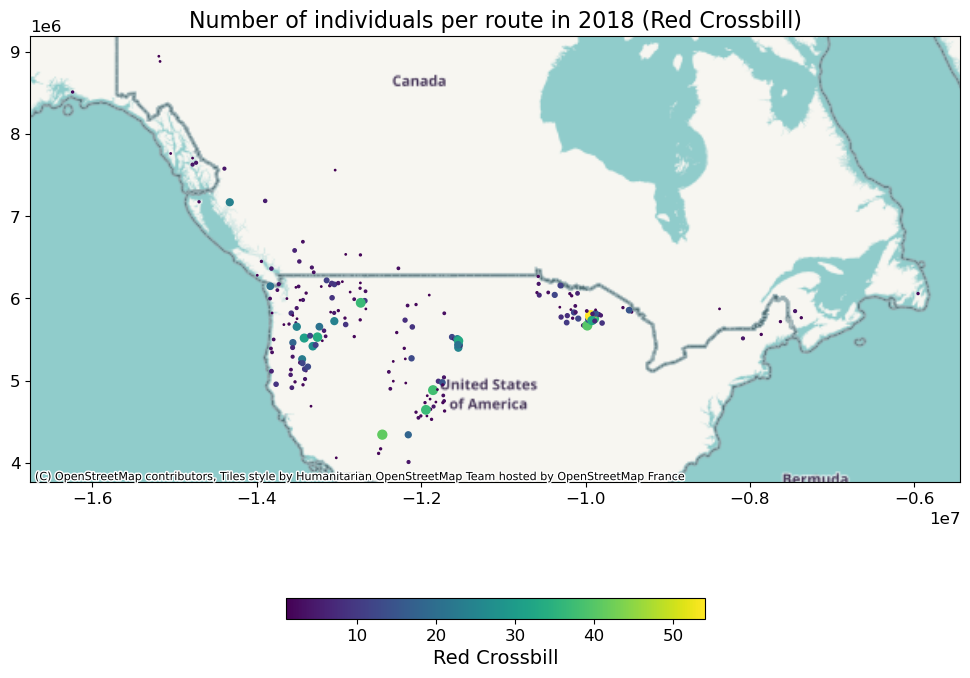

In [23]:
import geopandas as gpd
import contextily as ctx

yr  = 2018 # Plot the number of individuals per route for the specified species in 2022

subTotals = Totals[Totals['AOU']==spp][['Year','ruta','Longitude','Latitude','Number of individuals']]
# Totals.columns
geototals = gpd.GeoDataFrame(
    subTotals, geometry=gpd.points_from_xy(subTotals.Longitude, subTotals.Latitude), crs="EPSG:4326"
)


geototals = geototals.to_crs(epsg=3857)

# ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax = geototals[geototals['Year']==yr].plot('Number of individuals', cmap='viridis',  markersize='Number of individuals', 
                                             legend=True,
                                             legend_kwds={'shrink': 0.45,'label':sppname,'orientation': 'horizontal'},  # Adjust the shrink value (e.g., 0.5 for 50%)
                                             figsize=(12, 10),
                                             )
# cbar = plt.colorbar(shrink=0.75)
ax.set_title('Number of individuals per route in '+str(yr)+' ('+sppname+')')
ctx.add_basemap(ax)



# Writing data to a dictionary

The dictionary is organized as follows:

- key: (species, routeID)
- value: [(year, abundance)] 

routeID is composed by joining 'Country Number' `Totals['CountryNum'].astype(str)`, 'State Number' `Totals['StateNum'].astype(str)`, and 'Route Number' `Totals['Route'].astype(str)`

We will pad the timeseries, starting in 1966 with 0s for those years in which birds were not counted

In [36]:
first_year = 1966
last_year = 2024

totals_dict = {}

# Group the DataFrame by 'Year' and 'RouteDataID'
# Then iterate through each group
for (spp, route_id), group_df in Totals.groupby(['AOU', 'ruta']):
        # Extract the 'Totals' column for the current group and convert it to a list
        totals_list = list(zip(group_df['Year'].tolist(), group_df['Number of individuals'].tolist()))
        # Add the (spp, route_id) tuple as key and the list of totals as value to the dictionary
        totals_dict[(str(spp), str(route_id))] = fill_missing_year_data(totals_list, first_year, last_year)   #totals_list

We may now extract the data by parsing the dictionary. 

Here are a couple functions that will:

- generate a pandas DataFrame for a given species with routeID as columns and years as rows
- for a given routeID, species as columns and years as rows
- for a given year, species as columns and routes rows

you may then export this to a csv if needed

**Examples**

- species: '10'  --Western Grebe (_Aechmophorus,occidentalis_)
- routeID: '1241120'
- year: 2018

In [ ]:
species_df = species_to_df('5210',totals_dict)

# routes_df = route_to_df('1241120',totals_dict)
# yrs_df = year_to_df(2018,totals_dict)



In [55]:
species_df.loc[species_df.index > 1996]

Route,1240410,12404123,12404125,12404141,1240415,12404157,1240416,1240417,12404196,12404201,...,8409272,8409275,8409277,8409284,8409286,8409287,8409288,84092901,84092902,8409293
Year,,,,,,,,,,,,,,,,,,,,,
1997,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,14,0,0,0,0
1998,0,6,82,0,0,0,0,1,0,0,...,0,0,0,0,0,35,0,0,0,0
1999,0,0,0,0,0,0,17,2,3,0,...,0,0,3,0,2,15,0,0,0,0
2000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,23,20,0,7,0,0
2001,0,0,1,0,0,0,0,0,0,3,...,0,0,0,0,10,6,0,12,0,0
2002,0,0,0,0,0,0,10,0,0,8,...,0,0,7,0,4,15,0,1,0,0
2003,0,0,6,0,0,0,0,0,1,1,...,0,0,4,0,11,8,0,0,0,0
2004,0,0,0,0,0,1,0,0,0,10,...,0,0,13,0,23,14,0,0,4,0
2005,0,0,1,1,0,1,0,0,0,0,...,0,0,11,0,5,64,1,5,5,0


/home/horo/miniconda3/envs/BBS_PabloM_Rolando_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Route', ylabel='Year'>

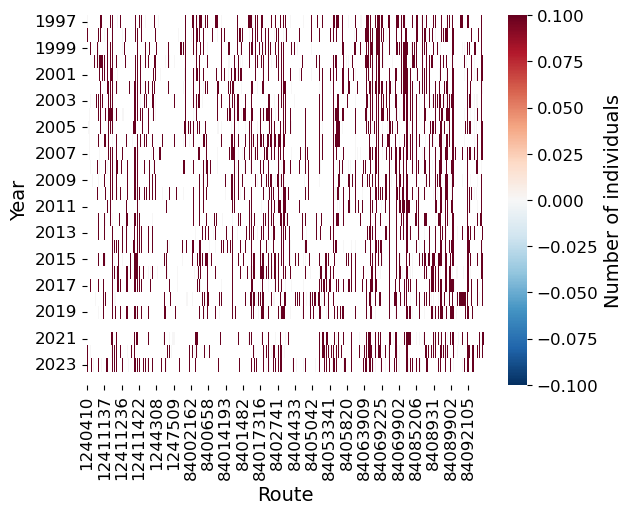

In [56]:
log_species_df = species_df.loc[species_df.index > 1996].apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x)
sns.heatmap(log_species_df,linewidths=0.0, cmap='RdBu_r', cbar_kws={'label': 'Number of individuals'})

# Generate webpage
We will generate a webpage with the summary data to better visualize an aggregated abundance across all routes in the US 

In [22]:
generate_species_webpage('spp_summaries.csv','figs/')

Removed 'Unnamed: 0' column.
Webpage 'species_webpage.html' generated successfully!


# Relevant Timeseries

- timeseries of route starting after 1980
- timeseries with at least 35 years of data
- species with at least 500 routes

This yields a total of 25 species.

In [34]:
# species_to_df(spp.astype('str'),totals_dict)
spp.astype('str')

np.str_('52021')

In [ ]:
print('AOU:',filtd['AOU'].tolist()[1])
print(filtd.iloc[1,:])
kk = species_to_df(str(filtd['AOU'].tolist()[1]),totals_dict).T
display(kk)

AOU: 3310
AOU                                 3310
n_rutas                             8439
first_year                          1982
last_year                           2023
timeseries length                     41
English_Common_Name     Northern Harrier
French_Common_Name     Busard des marais
Order                    Accipitriformes
Family                      Accipitridae
Genus                             Circus
Species                        hudsonius
Name: 258, dtype: object


Year,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Route,,,,,,,,,,,,,,,,,,,,,
1241110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12411137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241116,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1241117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84092901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8409293,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,3,1,0
8409296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.merge(kk,routes[['ruta','Latitude','Longitude']],left_index=True,right_on='ruta',how='left')
# kk.index
# routes.columns

,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,...,2018,2019,2020,2021,2022,2023,2024,ruta,Latitude,Longitude
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241110,49.294880,-121.688470
639,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241111,49.184020,-122.534780
710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12411137,60.001790,-134.660260
644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241116,50.239270,-115.874490
645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241117,50.924350,-116.478390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,84092901,44.771872,-110.457771
5719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,8409293,41.265669,-110.263694
5721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8409296,41.657303,-109.224754
5722,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,8409297,41.569733,-109.183578


In [ ]:
dir = 'output/'

names = {}
for i in filtd['AOU'].tolist():
    # print('[ Processing ] AOU:',i)
    # print(spps[spps['AOU']==i][['AOU','English_Common_Name','Order','Family','Genus','Species']].values.tolist())
    names[i] = spps[spps['AOU']==i][['English_Common_Name','Order','Family','Genus','Species']].values.tolist()
    tmp = species_to_df(str(i),totals_dict).T
    pd.merge(tmp,routes[['ruta','Latitude','Longitude']],left_index=True,right_on='ruta',how='left').to_csv(dir+'species_'+str(i)+'.csv')



flattened_data_dict = {k: v[0] for k, v in names.items()}

names = pd.DataFrame.from_dict(flattened_data_dict,orient='index').reset_index()
names.columns = ['AOU','English_Common_Name','Order','Family','Genus','Species']

names.to_csv(dir+'species_names.csv',index=False)

# Relevant routes

We will define a relevant route as having:
- a set of long time series, that is, with spp that have been well surveyed
- with species having timeseries with continuous presence (few zeros)
- Mostly passeriformes  

In [ ]:
# print("Original DataFrame head:")
# print(Totals.head())
print("\nOriginal DataFrame info:")
Totals.info()



Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4085893 entries, 0 to 4085892
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   RouteDataID            int64  
 1   CountryNum             int64  
 2   StateNum               int64  
 3   Route                  int64  
 4   RPID                   int64  
 5   Year                   int64  
 6   AOU                    int64  
 7   Number of individuals  int64  
 8   ruta                   object 
 9   RouteName              object 
 10  Active                 int64  
 11  Latitude               float64
 12  Longitude              float64
 13  Stratum                int64  
 14  BCR                    int64  
 15  RouteTypeID            int64  
 16  RouteTypeDetailID      int64  
dtypes: float64(2), int64(13), object(2)
memory usage: 529.9+ MB


## Filter the data for quality and relevant years ---
The `abundance_col` argument should match the name of your abundance column.

Common names are `Number of individuals`, `SpeciesTotal`, or simply `count`.


In [31]:
Totals[['AOU','ruta','Year','Number of individuals','Latitude','Longitude']].head()

,AOU,ruta,Year,Number of individuals,Latitude,Longitude
0,1480,124431,2012,2,53.80272,-115.26551
1,1480,124431,2012,2,67.18229,-135.80258
2,2060,124431,2012,2,53.80272,-115.26551
3,2060,124431,2012,2,67.18229,-135.80258
4,2300,124431,2012,11,53.80272,-115.26551


In [28]:
abundance_column_name = 'Number of individuals'

filtered_df = filter_bbs_data(Totals, abundance_col=abundance_column_name)

print("\nFiltered DataFrame head:")
display(filtered_df)
# print("\nFiltered DataFrame info:")
# filtered_df.info()



Initial rows: 4085893


After filtering Year >= 1997: 4075420 rows
After excluding 2020: 4075420 rows
After filtering RPID == 101: 4050921 rows
After excluding specific AOU codes: 4034825 rows

Filtered DataFrame head:


,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Number of individuals,ruta,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID
0,6346138,124,43,1,101,2012,1480,2,124431,RONAN,1,53.802720,-115.265510,29,6,1,1
1,6346138,124,43,1,101,2012,1480,2,124431,RICHARDSON,1,67.182290,-135.802580,25,6,1,1
2,6346138,124,43,1,101,2012,2060,2,124431,RONAN,1,53.802720,-115.265510,29,6,1,1
3,6346138,124,43,1,101,2012,2060,2,124431,RICHARDSON,1,67.182290,-135.802580,25,6,1,1
4,6346138,124,43,1,101,2012,2300,11,124431,RONAN,1,53.802720,-115.265510,29,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4085888,6382865,840,63,917,101,2023,7180,13,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2
4085889,6382865,840,63,917,101,2023,7310,1,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2
4085890,6382865,840,63,917,101,2023,7360,4,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2
4085891,6382865,840,63,917,101,2023,7550,2,84063917,Cherokee,1,35.516915,-83.294801,23,28,1,2


In [26]:
filtered_df['Year'].describe()

count    4.034825e+06
mean     2.009669e+03
std      7.598177e+00
min      1.997000e+03
25%      2.003000e+03
50%      2.010000e+03
75%      2.016000e+03
max      2.023000e+03
Name: Year, dtype: float64

## Calculate species presence metrics

Adjust `presence_threshold` as needed. 0.8 means a species must be present in at least 80% of the years the route was surveyed.


In [ ]:

species_presence_results = calculate_species_presence(
    filtered_df,
    abundance_col='Number of individuals',
    presence_threshold=0.9
)

print("\nSpecies Presence Results head:")
display(species_presence_results)



Calculating species presence metrics...
Calculated presence metrics for 397435 species-route combinations.

Species Presence Results head:


,ruta,AOU,total_survey_years_for_route,years_with_presence,presence_ratio,is_continuously_present
0,124111,440,10,2,0.2,False
1,124111,1320,10,6,0.6,False
2,124111,1390,10,1,0.1,False
3,124111,1720,10,8,0.8,False
4,124111,1940,10,5,0.5,False
...,...,...,...,...,...,...
397430,8409299,6882,2,1,0.5,False
397431,8409299,7020,2,2,1.0,True
397432,8409299,7150,2,2,1.0,True
397433,8409299,7610,2,2,1.0,True


In [ ]:
# species_presence_results

# # Filter for only continuously present species
# continuous_species_on_routes = species_presence_results[
#     species_presence_results['is_continuously_present'] == True
# ].copy()

# continuous_species_on_routes.groupby('ruta').size().reset_index(name='num_continuous_species')

# continuous_species_on_routes.groupby('ruta').size().reset_index(name='num_continuous_species')

## Identify the top routes with longest time series of continuous species
Adjust `top_n_routes` to see more or fewer top routes.

In [ ]:

top_quality_routes = identify_long_timeseries_routes(filtered_df, species_presence_results)

print("\nTop Routes with Longest Time Series of Continuously Present Species:")

display(top_quality_routes.sort_values(by=['num_survey_years','num_continuous_species'],ascending=False))



Identifying routes with longest time series of continuously present species...



Top Routes with Longest Time Series of Continuously Present Species:


,ruta,num_continuous_species,min_year,max_year,num_survey_years,Latitude,Longitude
1276,84063903,36,1995,2023,28,34.730060,-76.935921
1528,840341,34,1982,2023,28,64.546414,-146.994859
1529,840341,34,1982,2023,28,42.210196,-90.060372
90,8407235,55,1996,2023,27,41.228900,-76.456000
125,84072132,53,1996,2023,27,41.546735,-76.962825
...,...,...,...,...,...,...,...
3922,8401463,18,1997,1997,1,35.818032,-117.342044
3923,8409280,18,2012,2012,1,42.872871,-107.524437
4114,8409298,16,2001,2001,1,41.889976,-108.840195
4403,8406106,12,1997,1997,1,35.866379,-114.661987


Use `top_quality_routes` for further analysis, mapping, or reporting.

For example, to get just the route IDs:

In [ ]:
n_routes=15
print("\nRoute IDs of top quality routes:")
top_quality_routes.sort_values(by=['num_survey_years','num_continuous_species'],ascending=False)['ruta'].iloc[:n_routes]
# print(top_quality_routes['ruta'].tolist())




Route IDs of top quality routes:


1276    84063903
1528      840341
1529      840341
90       8407235
125     84072132
148      8407229
149      8407234
250      8407236
301     84014153
345      8401498
917     12476306
1026     8405920
1277     8408823
1530    12445101
1667     8408919
Name: ruta, dtype: object

To get the full data for a specific top route:
    


In [ ]:
# example_top_route = top_quality_routes.iloc[0]['ruta']
# data_for_example_route = filtered_df[filtered_df['ruta'] == example_top_route]
# print(f"\nData for top route {example_top_route}:")
# print(data_for_example_route.head())

